### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor as RF
from catboost import CatBoostRegressor as CB
from sklearn.metrics import r2_score as R2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    # дописать документация
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Пути к директориям и файлам

In [5]:
TRAIN_DATASET_PATH = 'project_data/project_task/train.csv' # y_train, y_valid
TEST_DATASET_PATH = 'project_data/project_task/test.csv'

In [6]:
train_set = pd.read_csv(TRAIN_DATASET_PATH)
train_set.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [7]:
# исправим название колонки Helthcare_2 в train:
cols = train_set.columns
for i in cols:
    if i == 'Helthcare_2':
        train_set = train_set.rename(columns={'Helthcare_2':'Healthcare_2'})

In [8]:
train_set.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [9]:
test_set = pd.read_csv(TEST_DATASET_PATH)
test_set.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [10]:
# исправим название колонки Helthcare_2 в test:
cols = test_set.columns
for i in cols:
    if i == 'Helthcare_2':
        test_set = test_set.rename(columns={'Helthcare_2':'Healthcare_2'})

In [11]:
test_set.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


#### - Далее работаем с train:

In [12]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Healthcare_2   10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

### Приведение типов

In [13]:
train_set.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

In [14]:
train_set['Id'] = train_set['Id'].astype(str)
train_set['DistrictId'] = train_set['DistrictId'].astype(str)

### Обзор данных

__Целевая переменная__

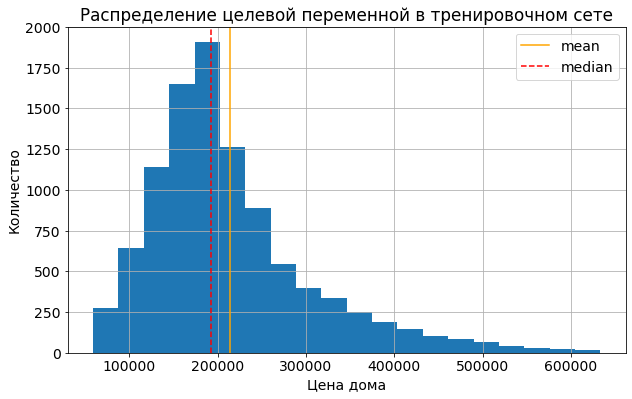

In [15]:
plt.figure(figsize = (10, 6))

train_set['Price'].hist(bins=20)
plt.axvline(x=train_set['Price'].mean(), label='mean', color='orange')
plt.axvline(x=train_set['Price'].median(), label='median', linestyle='--', color='red')

plt.ylabel('Количество')
plt.xlabel('Цена дома')
plt.title('Распределение целевой переменной в тренировочном сете')
plt.legend()
plt.show()

__Количественные переменные__

In [16]:
train_set.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [17]:
train_set_num_features = train_set.select_dtypes(include=['float64', 'float32', 'float16', 'int64'])
train_set_num_features.drop('Price', axis=1, inplace=True)

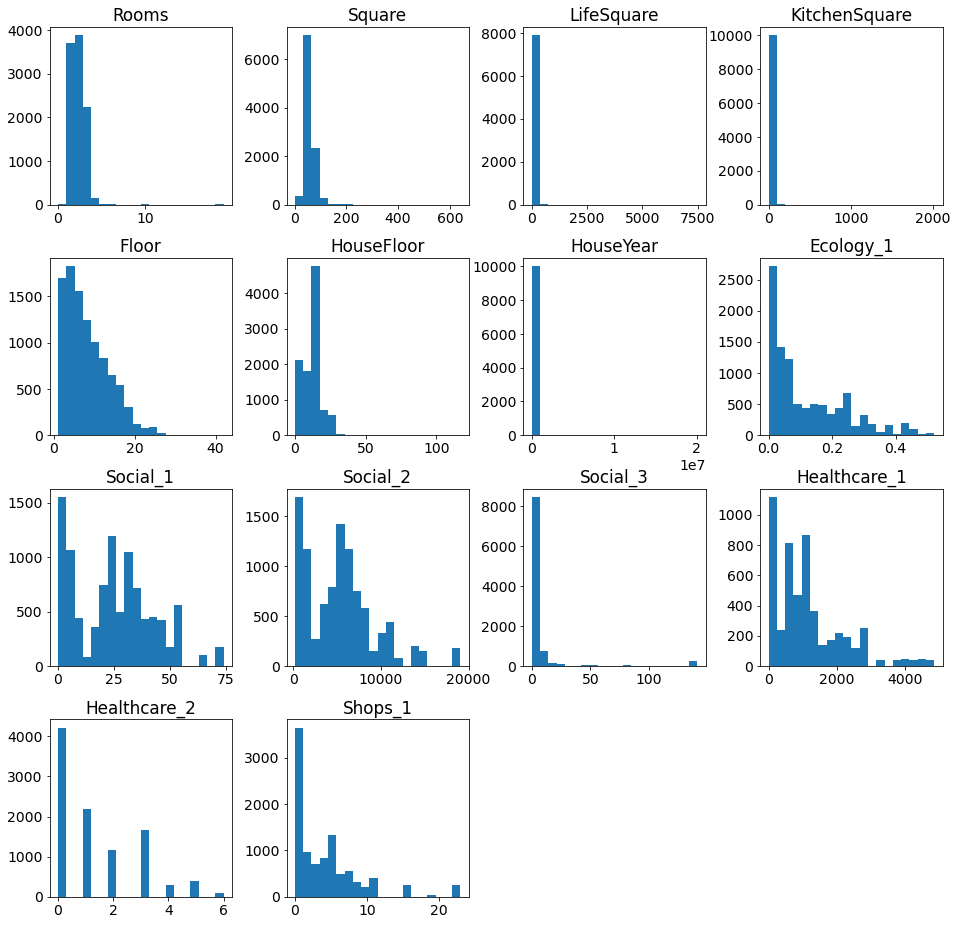

In [18]:
train_set_num_features.hist(figsize=(16,16), bins=20, grid=False);

1) __Square__, __LifeSquare__ и __KitchenSquare__ являются зависимыми переменными.

In [19]:
train_set['Square'].value_counts().sort_index()

1.136859      1
1.988943      1
2.377248      1
2.596351      1
2.954309      1
             ..
212.932361    1
275.645284    1
409.425181    1
604.705972    1
641.065193    1
Name: Square, Length: 10000, dtype: int64

In [20]:
train_set['LifeSquare'].value_counts().sort_index()

0.370619       1
0.641822       1
0.795539       1
0.873147       1
1.049867       1
              ..
263.542020     1
410.639749     1
461.463614     1
638.163193     1
7480.592129    1
Name: LifeSquare, Length: 7887, dtype: int64

In [21]:
train_set['KitchenSquare'].value_counts().sort_index()

0.0        697
1.0       2460
2.0          4
3.0         22
4.0         39
5.0       1169
6.0       1038
7.0        609
8.0       1306
9.0        843
10.0      1075
11.0       233
12.0       249
13.0        67
14.0        51
15.0        31
16.0        16
17.0        12
18.0         6
19.0        11
20.0        14
21.0         1
22.0         3
23.0         1
25.0         2
26.0         1
27.0         1
29.0         1
30.0         2
31.0         1
32.0         2
35.0         1
36.0         1
37.0         2
39.0         1
40.0         1
41.0         2
42.0         1
43.0         2
48.0         1
51.0         2
53.0         1
54.0         1
58.0         2
60.0         1
62.0         1
63.0         1
66.0         1
72.0         1
73.0         1
75.0         1
78.0         1
84.0         1
96.0         1
112.0        2
123.0        1
1970.0       1
2014.0       1
Name: KitchenSquare, dtype: int64

Значения __KitchenSquare__ равные 0 заменим на разность __LifeSquare__ и  __Square__

2) __Rooms__

In [22]:
train_set['Rooms'].value_counts().sort_index()

0.0        8
1.0     3705
2.0     3880
3.0     2235
4.0      150
5.0       18
6.0        1
10.0       2
19.0       1
Name: Rooms, dtype: int64

In [23]:
train_set.nsmallest(10, 'Rooms')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,95380.220993


In [24]:
train_set.nlargest(5, 'Rooms')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416
1422,4282,195,5.0,95.617533,62.377052,7.0,7,7.0,1940,0.015017,B,B,17,3079,59,2890.0,0,8,B,479525.147323


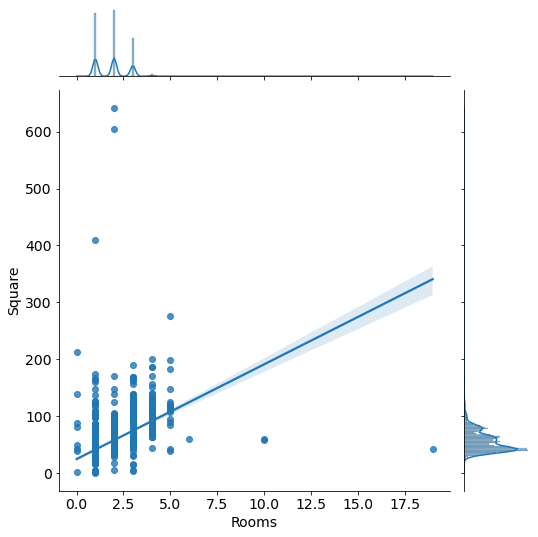

In [25]:
grid = sns.jointplot(train_set['Rooms'], train_set['Square'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

__Вывод:__<br>
Значения __Rooms__ меньше 1 и больше 5 являются выбросами, будем заменять на значения в зависимости от __Square__.

1) __HouseYear__

In [26]:
train_set['HouseYear'].value_counts().sort_index()

1910          1
1912          2
1914          1
1916          1
1917          3
           ... 
2018        175
2019         79
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 97, dtype: int64

__Вывод:__<br>
Значения __4968__ и __20052011__ некорректны, __4968__ заменим на 1968, а __20052011__ заменим на среднее 2005 и 2011, т.е. на 2008.

__Категориальные переменные__

In [27]:
cat_colnames = train_set.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [28]:
for cat_colname in cat_colnames[2:]:
    print(str(cat_colname) + '\n\n' + str(train_set[cat_colname].value_counts()) + '\n' + '-' * 100 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
----------------------------------------------------------------------------------------------------

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
----------------------------------------------------------------------------------------------------

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
----------------------------------------------------------------------------------------------------



### Подготовка данных (обработка выбросов и пропусков, построение новых признаков)

In [29]:
# заменяем NaN нулями
def data_NaN(df_input):
    df_output = df_input.copy()
    df_output = df_output.fillna(0)
    return df_output

In [30]:
# приводим в порядок признак 'Rooms'
def clean_rooms(df_input):
    df_output = df_input.copy()
    
    idx = (df_output['Square'] < 25) & (df_output['Rooms'] == 0)
    df_output.loc[idx, 'Rooms'] = df_output.loc[idx, 'Rooms'] = 1

    idx = (df_output['Square'] < 50) & (df_output['Rooms'] == 0)
    df_output.loc[idx, 'Rooms'] = df_output.loc[idx, 'Rooms'] = 2
    
    idx = (df_output['Square'] < 75) & (df_output['Rooms'] == 0)
    df_output.loc[idx, 'Rooms'] = df_output.loc[idx, 'Rooms'] = 3
    
    idx = (df_output['Square'] < 100) & (df_output['Rooms'] == 0)
    df_output.loc[idx, 'Rooms'] = df_output.loc[idx, 'Rooms'] = 4
    
    idx = (df_output['Square'] < 150) & (df_output['Rooms'] == 0)
    df_output.loc[idx, 'Rooms'] = df_output.loc[idx, 'Rooms'] = 5
    
    df_output.loc[df_output['Rooms'] == 0, 'Rooms'] = 6
    
    idx = (df_output['Square'] < 150) & (df_output['Rooms'] >= 6)
    df_output.loc[idx, 'Rooms'] = df_output.loc[idx, 'Rooms'] = 5
    
    idx = (df_output['Square'] < 100) & (df_output['Rooms'] > 5)
    df_output.loc[idx, 'Rooms'] = df_output.loc[idx, 'Rooms'] = 3
    
    idx = (df_output['Square'] < 75) & (df_output['Rooms'] > 4)
    df_output.loc[idx, 'Rooms'] = df_output.loc[idx, 'Rooms'] = 3
    
    idx = (df_output['Square'] < 50) & (df_output['Rooms'] > 3)
    df_output.loc[idx, 'Rooms'] = df_output.loc[idx, 'Rooms'] = 2 
    
    idx = (df_output['Square'] < 25) & (df_output['Rooms'] > 2)
    df_output.loc[idx, 'Rooms'] = df_output.loc[idx, 'Rooms'] = 1
    
    idx = (df_output['Square'] > 150) & (df_output['Rooms'] < 6)
    df_output.loc[idx, 'Rooms'] = df_output.loc[idx, 'Rooms'] = 6
    
    idx = (df_output['Square'] > 100) & (df_output['Rooms'] < 4)
    df_output.loc[idx, 'Rooms'] = df_output.loc[idx, 'Rooms'] = 5

    return df_output

In [31]:
def clean_other(df_input):
    
    df_output = df_input.copy()
    
    idx = (df_output['LifeSquare'] < 15)
    df_output.loc[idx, 'LifeSquare'] = df_output.loc[idx, 'LifeSquare'] = 15
    
    idx = (df_output['LifeSquare'] > df_output['Square'])
    df_output.loc[idx, 'LifeSquare'] = df_output.loc[idx, 'Square']
    
    Square = dict(df_output.groupby('Rooms')['Square'].median())
    idx = (df_output['Square'] < 15) & (df_output['Rooms'] < 2)
    df_output.loc[idx, 'Square'] = df_output.loc[idx, 'Rooms'].apply(lambda x: Square[x])
    
    idx = (df_output['Square'] < 30) & (df_output['Rooms'] > 1)
    df_output.loc[idx, 'Square'] = df_output.loc[idx, 'Rooms'].apply(lambda x: Square[x])
    
    idx = (df_output['Square'] < 30) & (df_output['Rooms'] > 1)
    df_output.loc[idx, 'Square'] = df_output.loc[idx, 'Rooms'].apply(lambda x: Square[x])
    
    LifeSquare = dict(df_output.groupby('Rooms')['LifeSquare'].median())
    idx = (df_output['LifeSquare'] < 15)
    df_output.loc[idx, 'LifeSquare'] = df_output.loc[idx, 'Rooms'].apply(lambda x: LifeSquare[x])

    idx = (df_output['KitchenSquare'] == 0)
    df_output.loc[idx, 'KitchenSquare'] = df_output.loc[idx, 'KitchenSquare'] = 6
    
    KitchenSquare = dict(df_output.groupby('Rooms')['KitchenSquare'].median())
    idx = (df_output['Rooms'] > 0)
    df_output.loc[idx, 'KitchenSquare'] = df_output.loc[idx, 'Rooms'].apply(lambda x: KitchenSquare[x])
    
    idx = (df_output['HouseFloor'] < df_output['Floor'])
    df_output.loc[idx, 'HouseFloor'] = df_output.loc[idx, 'Floor']
    
    # исправляем значения HouseYear    
    idx = (df_output['HouseYear'] == 4968)
    df_output.loc[idx, 'HouseYear'] = 1968
    idx = (df_output['HouseYear'] == 20052011)
    df_output.loc[idx, 'HouseYear'] = 2008
       
    # заменяем NaN в колонке Healthcare_1 на медианное значение
    df_output['Healthcare_1'].fillna(df_output['Healthcare_1'].median(), inplace=True)
    
    # бинаризируем категориальные признаки 
    df_output['Ecology_2_bin'] = df_output['Ecology_2'].replace({'A':0, 'B':1})
    df_output['Ecology_3_bin'] = df_output['Ecology_3'].replace({'A':0, 'B':1})
    df_output['Shops_2_bin'] = df_output['Shops_2'].replace({'A':0, 'B':1})
    
    return df_output

In [32]:
def prepare_train(data):
    data = data_NaN(data)
    data = clean_rooms(data)
    data = clean_other(data)
    return data    

In [33]:
train_set_prepared = prepare_train(train_set)

In [34]:
train_set_prepared.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,0.0,0,11,B,184966.930730,1,1,1
1,15053,41,3.0,65.683640,40.049543,7.0,7,9.0,1978,0.000070,...,10309,1,240.0,1,16,B,300009.450063,1,1,1
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,...,7759,0,229.0,1,3,B,220925.908524,1,1,1
3,5809,58,2.0,53.352981,52.731512,6.0,8,17.0,1977,0.437885,...,5735,3,1084.0,0,5,B,175616.227217,1,1,1
4,10783,99,1.0,39.649192,23.776169,6.0,11,12.0,1976,0.012339,...,5776,1,2078.0,2,4,B,150226.531644,1,1,1


In [35]:
train_set_prepared.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.934100,56.370529,31.857239,6.248200,8.526700,13.435700,1984.86600,0.118858,24.687000,5352.157400,8.039200,594.538900,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500
std,0.914681,20.977100,18.933436,0.496811,5.241148,6.094012,18.41187,0.119025,17.532614,4006.799803,23.831875,932.112976,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139
min,1.000000,16.117154,15.000000,6.000000,1.000000,1.000000,1910.00000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000
25%,1.000000,41.782323,17.699123,6.000000,4.000000,9.000000,1974.00000,0.017647,6.000000,1564.000000,0.000000,0.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000
50%,2.000000,52.535436,28.912325,6.000000,7.000000,14.000000,1977.00000,0.075424,25.000000,5285.000000,2.000000,30.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000
75%,2.000000,65.900625,41.167913,6.000000,12.000000,17.000000,2001.00000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000
max,6.000000,641.065193,638.163193,10.000000,42.000000,117.000000,2020.00000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000


In [36]:
train_set_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Healthcare_2   10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [37]:
train_set_prepared_num_features = train_set_prepared.select_dtypes(include=['float64', 'float32', 'float16', 'int64'])
train_set_prepared_num_features.drop('Price', axis=1, inplace=True)

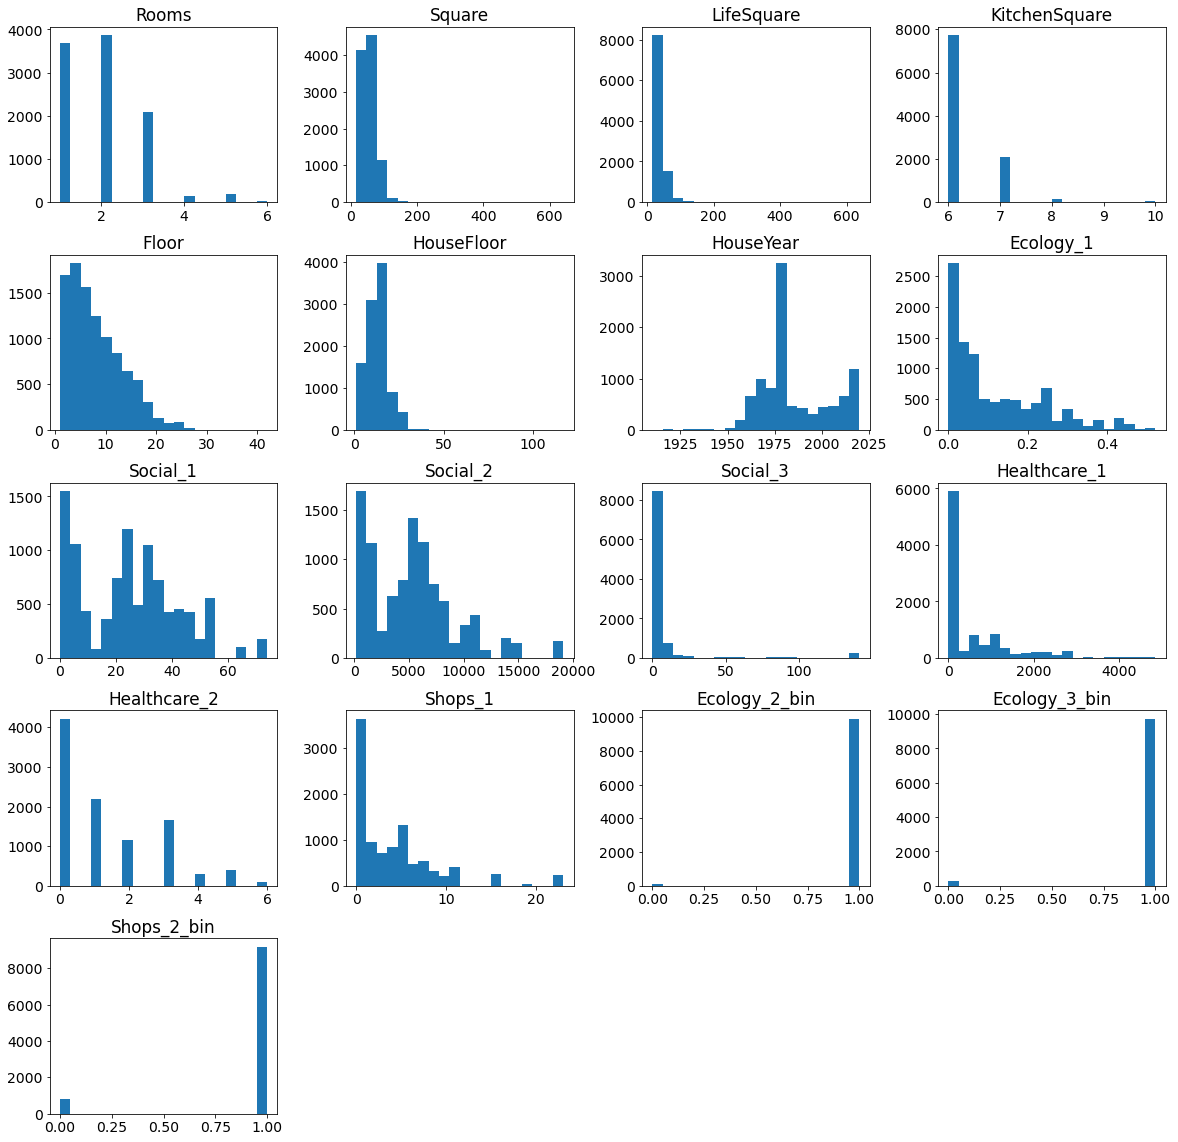

In [38]:
train_set_prepared_num_features.hist(figsize=(20,20), bins=20, grid=False);

### Отбор признаков

In [39]:
train_set_prepared.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Healthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin']

In [40]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
                 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2_bin',
                 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Shops_1', 'Shops_2_bin']

target_name = ['Price']

In [41]:
train_set_prepared.shape

(10000, 23)

### Разбиение на train и valid

In [44]:
X = train_set_prepared[feature_names]
y = train_set_prepared[target_name]

In [45]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,Shops_2_bin
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,0.0,11,1
1,41,3.0,65.683640,40.049543,7.0,7,9.0,1978,0.000070,1,1,46,10309,1,240.0,16,1
2,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,1,1,34,7759,0,229.0,3,1
3,58,2.0,53.352981,52.731512,6.0,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,5,1
4,99,1.0,39.649192,23.776169,6.0,11,12.0,1976,0.012339,1,1,35,5776,1,2078.0,4,1


In [46]:
y.head()

,Price
0,184966.930730
1,300009.450063
2,220925.908524
3,175616.227217
4,150226.531644


In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [48]:
y_train.head()

,Price
9239,130416.073182
6930,298237.106464
8136,170455.930747
3424,167876.802185
6518,76228.918314


### Построение и обучение модели

__RandomForest__

In [129]:
rf_model = RF(n_estimators=200,
              max_depth=15,
              max_features=0.5,
              min_samples_leaf=1,
              min_samples_split=5,
              random_state=42)

In [130]:
%%time
rf_model.fit(X_train, y_train)

Wall time: 2.19 s


RandomForestRegressor(max_depth=15, max_features=0.5, min_samples_split=5,
                      n_estimators=200, random_state=42)

В результате перебора разных моделей выбор сделан в пользу __Cat Boost Regressor__

In [131]:
cb_model = CB(
    iterations=100,
    depth=4,
    eval_metric='R2',
    silent=True
)

In [132]:
%%time
cb_model.fit(X_train, y_train)

Wall time: 192 ms


### Оценка модели

In [133]:
pred_train = rf_model.predict(X_train)
pred_train

array([164761.55579688, 281683.71622988, 162138.93049177, ...,
       225212.60762052, 309941.65029528, 142031.40539208])

In [134]:
pred_train.shape

(6700,)

In [135]:
R2(y_train, pred_train)

0.9209435575938952

In [136]:
pred_valid = rf_model.predict(X_valid)
pred_valid

array([ 94886.5136602 , 392628.33393174, 129815.60087596, ...,
       124379.36736701, 126610.75986568, 302952.24132322])

In [137]:
pred_valid.shape

(3300,)

In [138]:
R2(y_valid, pred_valid)

0.7283970339070881

In [139]:
y_train_preds = cb_model.predict(X_train)
y_test_preds = cb_model.predict(X_valid)

In [140]:
cb_model.best_score_

{'learn': {'R2': 0.8121794649817157, 'RMSE': 40145.12882317755}}

In [141]:
R2(y_train, y_train_preds)

0.812179465377338

### Проверка модели на тестовом датасете

In [62]:
test_set.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [63]:
test_set['Id'] = test_set['Id'].astype(str)
test_set['DistrictId'] = test_set['DistrictId'].astype(str)

In [64]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Healthcare_2   5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [65]:
def prepare_test(data):
    data = data_NaN(data)
    data = clean_rooms(data)
    data = clean_other(data)
    return data    

In [66]:
test_set = prepare_test(test_set)

In [67]:
test_set.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
4995,8180,11,3.0,67.133911,50.809797,7.0,5,9.0,1973,0.000170,...,36,5992,0,0.0,1,1,B,1,1,1
4996,4695,1,1.0,40.198472,21.807061,6.0,12,17.0,2017,0.007122,...,1,264,0,0.0,0,1,B,1,1,1
4997,5783,12,3.0,77.842178,48.282625,7.0,23,23.0,1989,0.090799,...,74,19083,2,0.0,5,15,B,1,1,1
4998,4780,62,2.0,81.305222,15.000000,6.0,4,4.0,1977,0.072158,...,2,629,1,0.0,0,0,A,1,1,0
4999,12504,30,2.0,60.555693,15.000000,6.0,10,17.0,1977,0.000078,...,22,6398,141,1046.0,3,23,B,1,1,1


In [68]:
%%time
test_set['Price'] = rf_model.predict(test_set.loc[:, feature_names])

Wall time: 281 ms


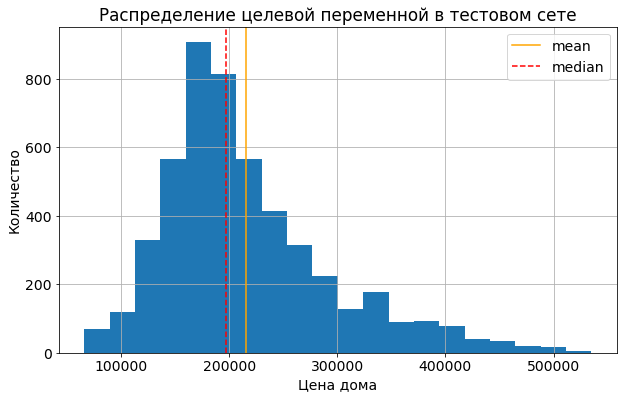

In [69]:
plt.figure(figsize = (10, 6))

test_set['Price'].hist(bins=20)
plt.axvline(x=test_set['Price'].mean(), label='mean', color='orange')
plt.axvline(x=test_set['Price'].median(), label='median', linestyle='--', color='red')

plt.ylabel('Количество')
plt.xlabel('Цена дома')
plt.title('Распределение целевой переменной в тестовом сете')
plt.legend()
plt.show()

In [70]:
%%time
test_set_pred = cb_model.predict(test_set.loc[:, feature_names])
test_set_pred

Wall time: 5.96 ms


array([168106.55146357, 205720.25894554, 256179.20524206, ...,
       343061.02378606, 187893.01680194, 176296.40986778])

### Формирование файла с прогнозами

In [72]:
test_id = test_set["Id"].copy()

result_df = pd.DataFrame()
result_df["Id"] = test_id
result_df["Price"] = pd.Series(test_set_pred)
result_df.to_csv("./MDemin_predictions.csv", index=False)

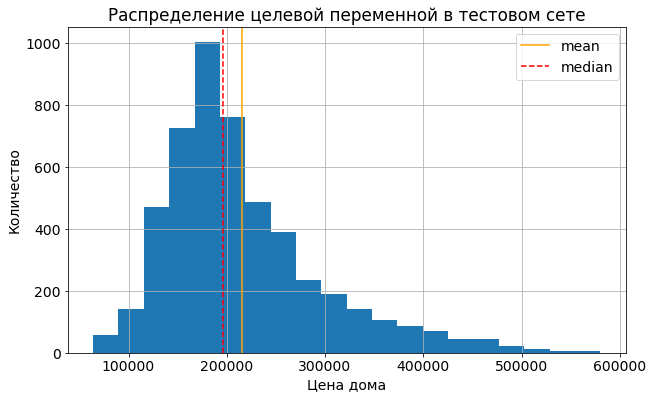

In [73]:
plt.figure(figsize = (10, 6))

result_df['Price'].hist(bins=20)
plt.axvline(x=result_df['Price'].mean(), label='mean', color='orange')
plt.axvline(x=result_df['Price'].median(), label='median', linestyle='--', color='red')

plt.ylabel('Количество')
plt.xlabel('Цена дома')
plt.title('Распределение целевой переменной в тестовом сете')
plt.legend()
plt.show()